# Train URL Classifier - Google Colab (Direct Upload)

**Instructions:**
1. Upload `phishtank_data.csv` when prompted
2. Run all cells
3. Download trained model at the end

**Model:** Random Forest with 17 URL features  
**Training time:** ~1-2 minutes  
**Expected accuracy:** 80-85%

In [1]:
!pip install numpy==1.26.4 scikit-learn==1.4.2 nltk==3.8.1 pandas==2.2.2 matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import pickle
import re
import math
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [3]:
def extract_url_features(url):
    """Extract 17 handcrafted features from URL"""
    try:
        parsed = urlparse(url)
        domain = parsed.netloc
        path = parsed.path

        suspicious_tlds = ['.tk', '.ml', '.ga', '.cf', '.gq', '.xyz', '.top', '.work', '.bid', '.win']
        url_shorteners = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'ow.ly', 'buff.ly']

        features = {
            'url_length': len(url),
            'domain_length': len(domain),
            'path_length': len(path),
            'has_https': 1 if parsed.scheme == 'https' else 0,
            'has_ip_address': 1 if re.match(r'\d+\.\d+\.\d+\.\d+', domain) else 0,
            'subdomain_count': domain.count('.') - 1 if domain else 0,
            'suspicious_tld': 1 if any(domain.endswith(tld) for tld in suspicious_tlds) else 0,
            'url_shortener': 1 if any(short in domain for short in url_shorteners) else 0,
            'special_char_count': len(re.findall(r'[^a-zA-Z0-9]', url)),
            'digit_count': len(re.findall(r'\d', url)),
            'digit_ratio': len(re.findall(r'\d', url)) / max(len(url), 1),
            'has_at_symbol': 1 if '@' in url else 0,
            'has_double_slash': 1 if '//' in path else 0,
            'path_depth': path.count('/'),
            'query_params_count': len(parsed.query.split('&')) if parsed.query else 0,
            'fragment_present': 1 if parsed.fragment else 0,
        }

        # Calculate entropy
        text = url.lower()
        if text:
            char_freq = {}
            for char in text:
                char_freq[char] = char_freq.get(char, 0) + 1
            entropy = -sum((freq / len(text)) * math.log2(freq / len(text)) for freq in char_freq.values())
            features['entropy'] = entropy
        else:
            features['entropy'] = 0.0

        return features
    except:
        # Default features if parsing fails
        return {k: 0 for k in ['url_length', 'domain_length', 'path_length', 'has_https',
                                'has_ip_address', 'subdomain_count', 'suspicious_tld',
                                'url_shortener', 'special_char_count', 'digit_count',
                                'digit_ratio', 'has_at_symbol', 'has_double_slash',
                                'path_depth', 'query_params_count', 'fragment_present', 'entropy']}

print("✓ Feature extraction function ready!")

✓ Feature extraction function ready!


In [4]:
data_file = '/content/phishtank_data.csv'
# Load PhishTank data
print("Loading PhishTank data...")
phishtank_df = pd.read_csv(data_file)
print(f"PhishTank dataset shape: {phishtank_df.shape}")
print(f"\nColumns: {phishtank_df.columns.tolist()}")
print(f"\nFirst few rows:")
phishtank_df.head()

Loading PhishTank data...
PhishTank dataset shape: (46978, 8)

Columns: ['phish_id', 'url', 'phish_detail_url', 'submission_time', 'verified', 'verification_time', 'online', 'target']

First few rows:


,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,9285474,https://wvqogxagyg.com%E2%88%95hepokYaE%E2%88%...,http://www.phishtank.com/phish_detail.php?phis...,2025-12-08T07:05:03+00:00,yes,2025-12-08T07:12:33+00:00,yes,Other
1,9285473,https://joxaf.cypres.cfd/if07v,http://www.phishtank.com/phish_detail.php?phis...,2025-12-08T07:01:52+00:00,yes,2025-12-08T07:12:33+00:00,yes,Other
2,9285472,https://rcbzw.cypres.cfd/gatway/check.php?r=,http://www.phishtank.com/phish_detail.php?phis...,2025-12-08T07:01:50+00:00,yes,2025-12-08T07:12:33+00:00,yes,Other
3,9285471,https://RCBZW.cypres.cfd/,http://www.phishtank.com/phish_detail.php?phis...,2025-12-08T07:01:49+00:00,yes,2025-12-08T07:12:33+00:00,yes,Other
4,9285469,https://oricowlugzqt.com%E2%88%95qbhiqo@rfwyvx...,http://www.phishtank.com/phish_detail.php?phis...,2025-12-08T06:55:21+00:00,yes,2025-12-08T07:03:09+00:00,yes,Other


In [5]:
# Extract phishing URLs
if 'url' in phishtank_df.columns:
    phishing_urls = phishtank_df['url'].dropna().head(1000).tolist()
    print(f"Loaded {len(phishing_urls)} phishing URLs from PhishTank")
else:
    print("ERROR: 'url' column not found in PhishTank data!")
    phishing_urls = []

# Create legitimate URLs dataset
legitimate_urls = [
    'https://www.google.com',
    'https://www.amazon.com/products',
    'https://github.com/user/repo',
    'https://www.paypal.com/myaccount',
    'https://stackoverflow.com/questions',
    'https://www.wikipedia.org',
    'https://www.reddit.com/r/python',
    'https://www.youtube.com/watch',
    'https://docs.python.org/3/',
    'https://www.netflix.com',
    'https://www.microsoft.com',
    'https://www.apple.com',
    'https://www.twitter.com',
    'https://www.facebook.com',
    'https://www.linkedin.com',
    'https://www.instagram.com',
    'https://www.github.com',
    'https://www.dropbox.com',
    'https://www.adobe.com',
    'https://www.slack.com'
]

# Balance dataset
legitimate_urls = legitimate_urls * (len(phishing_urls) // len(legitimate_urls) + 1)
legitimate_urls = legitimate_urls[:len(phishing_urls)]

# Combine into single dataset
df = pd.DataFrame({
    'url': phishing_urls + legitimate_urls,
    'label': ['phishing'] * len(phishing_urls) + ['legitimate'] * len(legitimate_urls)
})

print(f"\nCombined dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")

Loaded 1000 phishing URLs from PhishTank

Combined dataset shape: (2000, 2)

Class distribution:
label
phishing      1000
legitimate    1000
Name: count, dtype: int64


In [6]:
# Extract features for all URLs
print("Extracting URL features... (this may take a minute)\n")
features_list = []

for idx, url in enumerate(df['url']):
    if idx % 200 == 0:
        print(f"Processed {idx}/{len(df)} URLs...")
    features_list.append(extract_url_features(url))

features_df = pd.DataFrame(features_list)
print(f"\n✓ Feature extraction complete!")
print(f"Feature matrix shape: {features_df.shape}")
print(f"\nSample features:")
features_df.head()

Extracting URL features... (this may take a minute)

Processed 0/2000 URLs...
Processed 200/2000 URLs...
Processed 400/2000 URLs...
Processed 600/2000 URLs...
Processed 800/2000 URLs...
Processed 1000/2000 URLs...
Processed 1200/2000 URLs...
Processed 1400/2000 URLs...
Processed 1600/2000 URLs...
Processed 1800/2000 URLs...

✓ Feature extraction complete!
Feature matrix shape: (2000, 17)

Sample features:


,url_length,domain_length,path_length,has_https,has_ip_address,subdomain_count,suspicious_tld,url_shortener,special_char_count,digit_count,digit_ratio,has_at_symbol,has_double_slash,path_depth,query_params_count,fragment_present,entropy
0,127,118,1,1,0,2,0,0,23,25,0.196850,1,0,1,0,0,4.695031
1,30,16,6,1,0,1,0,0,6,2,0.066667,0,0,1,0,0,4.256565
2,44,16,17,1,0,1,0,0,10,0,0.000000,0,0,2,1,0,4.172405
3,25,16,1,1,0,1,0,0,6,0,0.000000,0,0,1,0,0,3.863465
4,51,42,1,1,0,1,0,1,10,5,0.098039,1,0,1,0,0,4.814103


In [7]:
X = features_df
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nTraining set distribution:\n{y_train.value_counts()}")

Training samples: 1600
Test samples: 400

Training set distribution:
label
phishing      800
legitimate    800
Name: count, dtype: int64


In [8]:
print("Training Random Forest model...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("✓ Training complete!")

Training Random Forest model...
✓ Training complete!


In [9]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"="*50)
print(f"ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"="*50)
print(f"\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred))

ACCURACY: 0.9975 (99.75%)

Detailed Classification Report:

              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00       200
    phishing       1.00      0.99      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



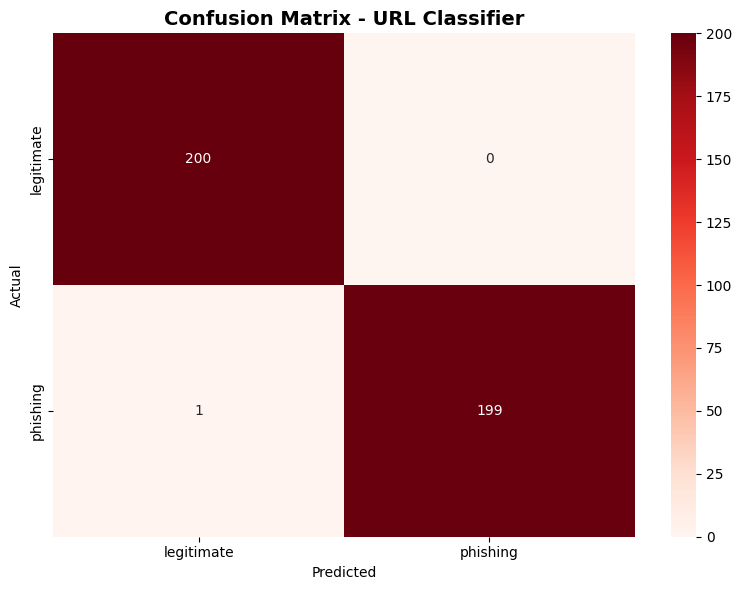

In [10]:
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - URL Classifier', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

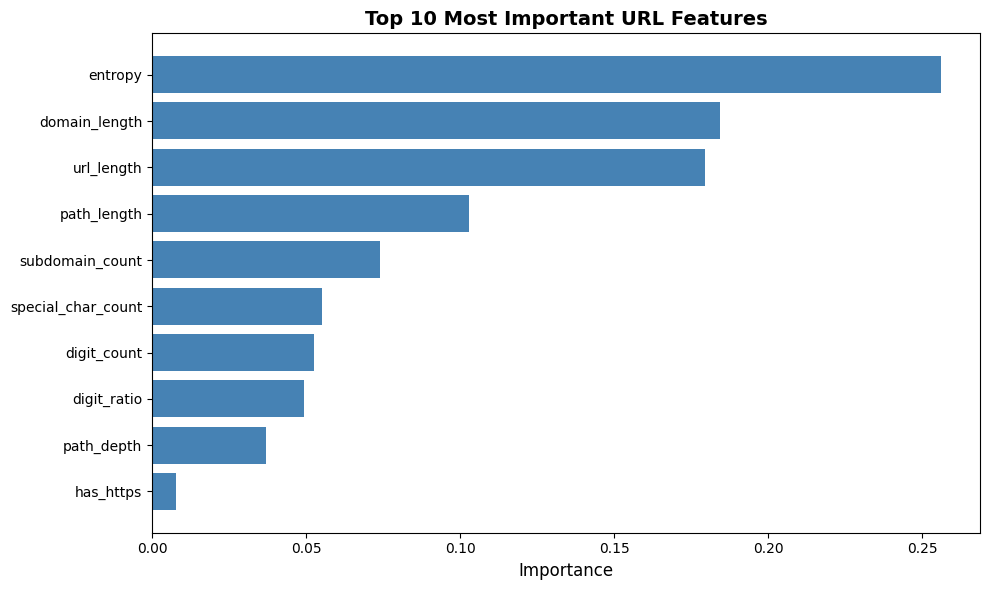


Top 10 Important Features:
           feature  importance
           entropy    0.256022
     domain_length    0.184507
        url_length    0.179393
       path_length    0.102798
   subdomain_count    0.074130
special_char_count    0.055073
       digit_count    0.052502
       digit_ratio    0.049248
        path_depth    0.036864
         has_https    0.007729


In [11]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Top 10 Most Important URL Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:")
print(feature_importance.head(10).to_string(index=False))

In [12]:
# Save model to file
with open('url_classifier_basic.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✓ Model saved!")

✓ Model saved!


In [13]:
# Test with sample URLs
test_urls = [
    "http://paypal-verify.tk/login.php",
    "https://www.google.com",
    "http://192.168.1.1/admin/login",
    "https://github.com/user/repository",
    "http://free-iphone.xyz/claim",
    "https://www.amazon.com/products"
]

print("Testing model with sample URLs:\n")
print("="*70)
for url in test_urls:
    features = extract_url_features(url)
    feature_vector = pd.DataFrame([features])
    prediction = model.predict(feature_vector)[0]
    probability = model.predict_proba(feature_vector)[0]
    confidence = max(probability)

    print(f"\nURL: {url}")
    print(f"Prediction: {prediction.upper()}")
    print(f"Confidence: {confidence:.2%}")
    print("-"*70)

Testing model with sample URLs:


URL: http://paypal-verify.tk/login.php
Prediction: PHISHING
Confidence: 84.00%
----------------------------------------------------------------------

URL: https://www.google.com
Prediction: LEGITIMATE
Confidence: 100.00%
----------------------------------------------------------------------

URL: http://192.168.1.1/admin/login
Prediction: PHISHING
Confidence: 97.00%
----------------------------------------------------------------------

URL: https://github.com/user/repository
Prediction: PHISHING
Confidence: 83.00%
----------------------------------------------------------------------

URL: http://free-iphone.xyz/claim
Prediction: PHISHING
Confidence: 95.00%
----------------------------------------------------------------------

URL: https://www.amazon.com/products
Prediction: LEGITIMATE
Confidence: 100.00%
----------------------------------------------------------------------
